# Установка библиотек

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 6.4 MB/s eta 0:00:00


In [ ]:
import gdown
import warnings
warnings.filterwarnings("ignore")
import os
import time
from sklearn.model_selection import train_test_split
import catboost
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import KFold, train_test_split

In [ ]:
pip install --upgrade gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


# Обработка данных

**Первичный анализ данных**

Cкачаем файлики

In [ ]:
!gdown 1MSUGOELyjXTFsSN1dOSj4tsmU-8c4YMo #беру их со своего гугл диска
!gdown 1pGQ-wJ3cxGS7pn_LruKMmBZkyLpWl7Q9
sample_submission = pd.read_csv('/content/sample_submission.csv')
df = pd.read_csv('/content/train (1).csv',  parse_dates=['order_completed_at'] )
assert sample_submission.shape[0] == 790449, 'что-то пошло не так 1'
assert df.shape[0] == 3123064, 'что-то пошло не так 2'
print('Все хорошо!')

Downloading...
From: https://drive.google.com/uc?id=1MSUGOELyjXTFsSN1dOSj4tsmU-8c4YMo
To: /content/sample_submission.csv
100% 8.64M/8.64M [00:00<00:00, 45.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pGQ-wJ3cxGS7pn_LruKMmBZkyLpWl7Q9
To: /content/train (1).csv
100% 89.6M/89.6M [00:01<00:00, 79.5MB/s]
Все хорошо!


In [ ]:
df.isna().sum()

user_id               0
order_completed_at    0
cart                  0
dtype: int64

Пропусков не замечено, что приятно

 **Анализ переменной cart**

 Tак, нам нужно сделать предсказание, для карты товара каждого юзера, посмотрим на распределение, и количество уникальных карт

Еще, ради интереса посмотрим насколько велик вклад карт, встречающихся в более чем 1% случаев

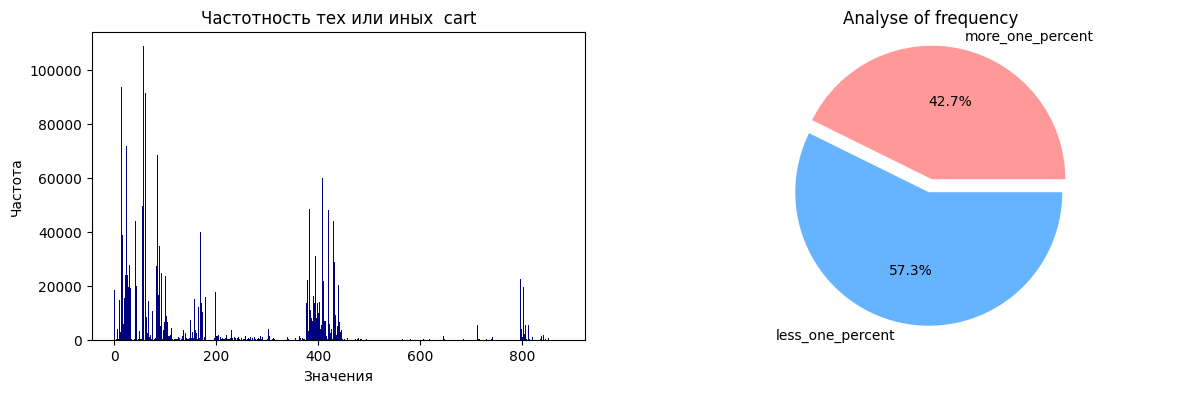

Количество уникальных карт 881
Количество карт, встречающихся чаще 1% случаев 24 и их процент от общего количетва 0.0007684760863049876


In [ ]:
#Рисуем гистиограмму
fig, axs = plt.subplots(1, 2, figsize=(14, 4))
axs[0].hist(df['cart'], bins= len(df['cart'].unique()), color='navy')
axs[0].set_xlabel('Значения')
axs[0].set_ylabel('Частота')
axs[0].set_title('Частотность тех или иных  cart')

#Рисуем pie plot
percent_of_each_cart =  df['cart'].value_counts()/df['cart'].count() * 100
more_one_percent = percent_of_each_cart[percent_of_each_cart>1] #отбираем только те карты, которые встречается чаще чем в 1% случаев
colors = ['#ff9999', '#66b3ff']  #делаем покрасивше и настраиваем цвета
explode = (0.1, 0)
values = [more_one_percent.sum(), 100 - more_one_percent.sum()] # считаем частотность ранее отобранных карт и их процент от общего колиества
labels = ['more_one_percent', 'less_one_percent']

axs[1].pie(values, labels=labels, autopct='%1.1f%%', colors = colors, explode= explode  )
axs[1].axis('equal')
axs[1].set_title('Analyse of frequency')
plt.show()
print('Количество уникальных карт', len(df['cart'].unique())) #Количество уникальных компонент 881 #исправить на f строку
print('Количество карт, встречающихся чаще 1% случаев', more_one_percent.shape[0], 'и их процент от общего количетва', more_one_percent.shape[0]/df['cart'].count()*100)


**Вывод:**
Частотность cart может быть полезной фичой, так ее  распределение, сильно варьируется от одной карты к другой, более того самые частотные карты (больше 1%), занимют больше 40% от всей выборки.


**Анализ времени**

Теперь посмтотрим на распределение времени по месяцам

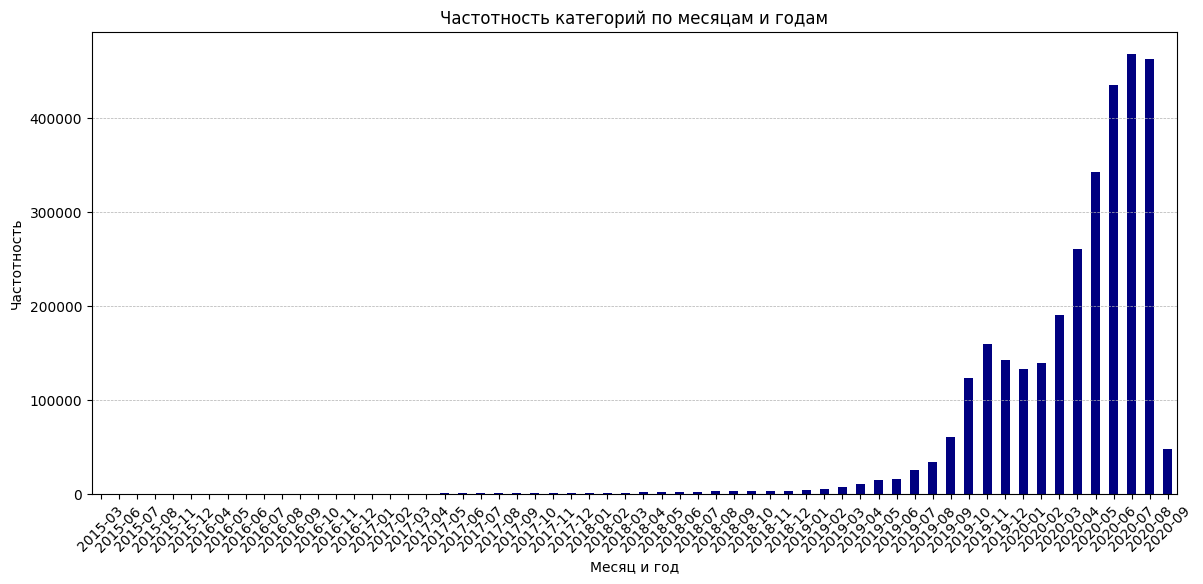

In [ ]:
# Создание столбчатой диаграммы
frequency = df['order_completed_at'].dt.strftime('%Y-%m').value_counts().sort_index()
plt.figure(figsize=(14, 6))
frequency.plot(kind='bar', color='navy')
plt.title('Частотность категорий по месяцам и годам')
plt.xlabel('Месяц и год')
plt.ylabel('Частотность')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

**Вывод**

Популярность платформы до 2019 года была очень невысокой, и забавный факт - самый мощный рост начался после начала короновируса, так, как люди начали массово переходит на онлайн и спрос на доставку вырос.

Отсюда возникает идея - проверить датафрейм на наличие спящих пользователей

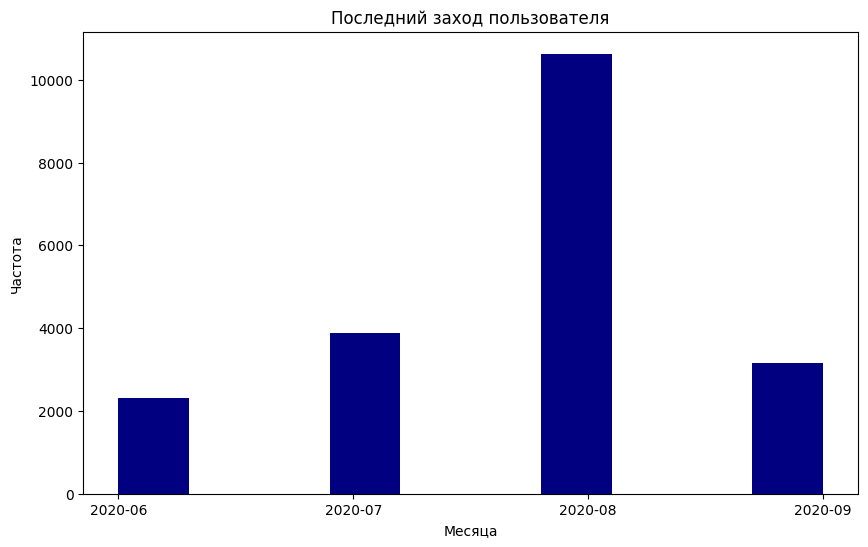

Cамый неактивный пользователь последний раз заходил 2020-06


In [ ]:
mounth_last = df.groupby('user_id')['order_completed_at'].max().reset_index()['order_completed_at'].dt.to_period('M').reset_index() #оставили дату последней покупик
mounth_last.sort_values(by = ['order_completed_at'], inplace = True)
plt.figure(figsize=(10, 6))
plt.hist(mounth_last['order_completed_at'].astype('str'),  color='navy') #количество бинов равно количеству уникальных карт
plt.xlabel('Месяца')
plt.ylabel('Частота')
plt.title('Последний заход пользователя')
plt.show()
print('Cамый неактивный пользователь последний раз заходил', mounth_last['order_completed_at'].min())

Явных спящих пользователей нет, однако в качестве потенциальной фичи можно попробовать, дату последнего захода пользователя можно попробовать

**Анализ появления новых карт**

Учитывая, что посещаемость так сильно выросла за последнее время, логично предположить, что и количество уникальных карт также сильно увеличилось за последнее время

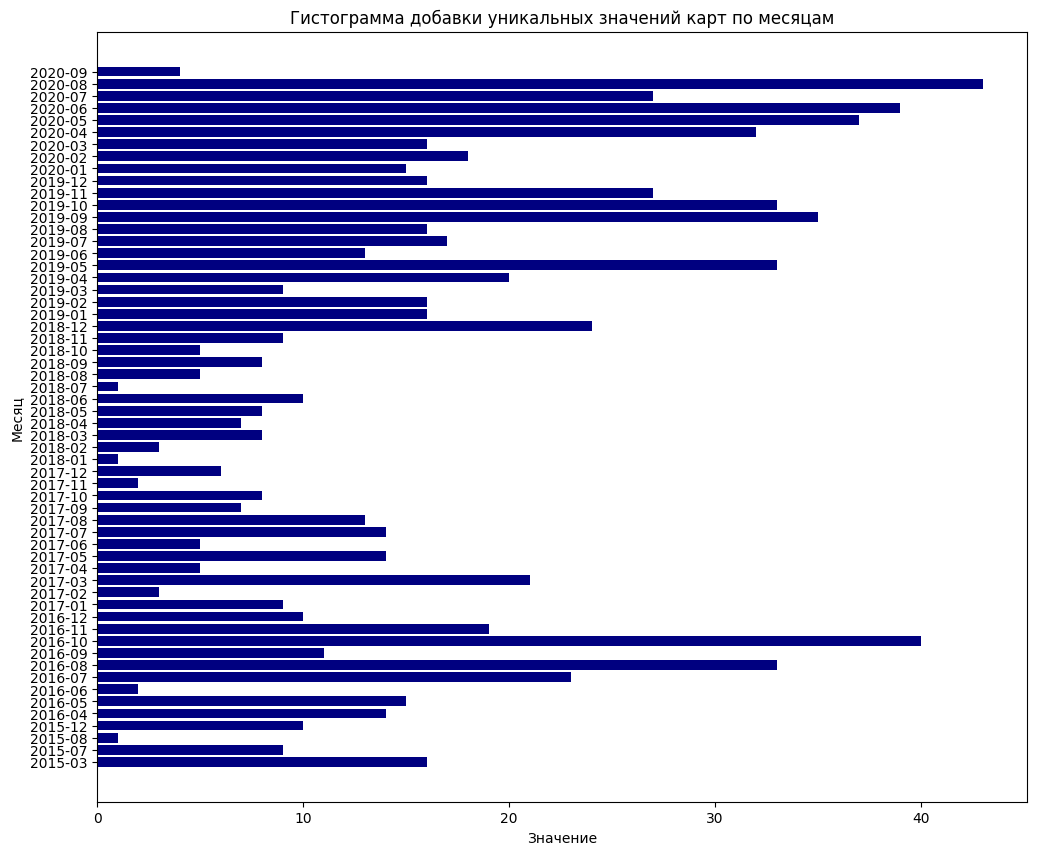

In [ ]:
preparation = df[['order_completed_at', 'cart']]
preparation ['month'] = preparation['order_completed_at'].dt.to_period('M')

finish = preparation.groupby('cart')['month'].min().reset_index()['month'].astype(str).value_counts().reset_index().sort_values(by = 'index')
finish.rename(columns = {'index':'month', 'month':'unique_cards'}, inplace= True)

plt.figure(figsize=(12, 10 ))
plt.barh(finish['month'], finish['unique_cards'], color='navy')
plt.title('Гистограмма добавки уникальных значений карт по месяцам')
plt.xlabel('Значение')
plt.ylabel('Месяц')
plt.show()

**Вывод**

Так как категории, в соответствии с начальным предположением добавляются каждый месяц, то сделать кросс валидацию, как во временных рядах будет крайне сложно, поэтому от такой идеи стоит отказаться

**Активность пользователя**

Посмотрем на встречаемость пользователей и попробуем понять насколько частотность того или иного пользователя вносит вклад в во всю выборку

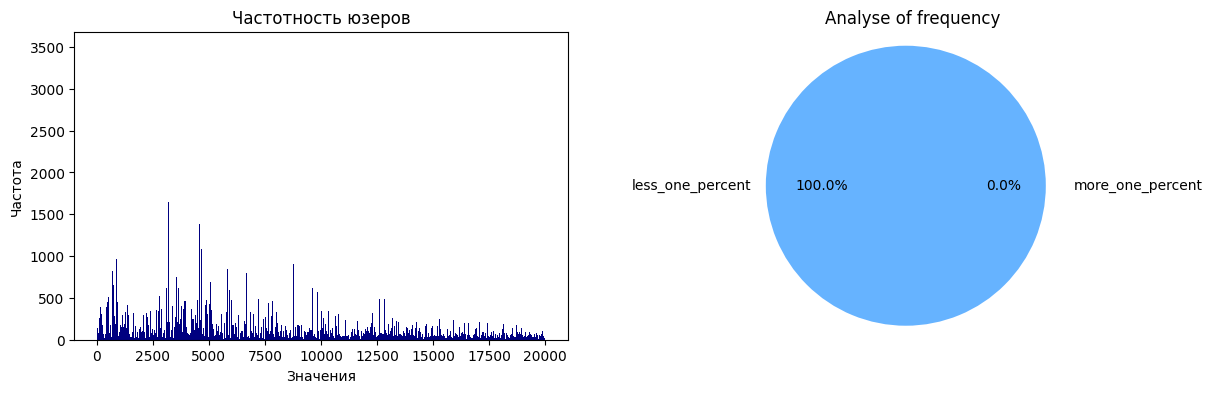

Количество уникальных юзеров 20000
Количество карт, встречающихся чаще 1% случаев 0 и их процент от общего количетва 0.0 %
Наибольшее количество заказов у одного юзера: 3508 a также процент его закзов 0.1123255879482457%


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))
axs[0].hist(df['user_id'], bins= 20000, color='navy')
axs[0].set_xlabel('Значения')
axs[0].set_ylabel('Частота')
axs[0].set_title('Частотность юзеров')


percent_of_each_user =  df['user_id'].value_counts()/df['user_id'].count() * 100
more_one_percent = percent_of_each_user[percent_of_each_user>1] #отбираем только те карты, которые встречается чаще чем в 1% случаев
colors = ['#ff9999', '#66b3ff']  #делаем покрасивше и настраиваем цвета
explode = (0.1, 0)
values = [more_one_percent.sum(), 100 - more_one_percent.sum()] # считаем частотность ранее отобранных карт и их процент от общего колиества
labels = ['more_one_percent', 'less_one_percent']

axs[1].pie(values, labels=labels, autopct='%1.1f%%', colors = colors, explode= explode  )
axs[1].axis('equal')
axs[1].set_title('Analyse of frequency')
plt.show()
print('Количество уникальных юзеров', len(df['user_id'].unique()))
print('Количество карт, встречающихся чаще 1% случаев', more_one_percent.shape[0], 'и их процент от общего количетва', \
      more_one_percent.shape[0]/df['cart'].count()*100, '%')
print(f'Наибольшее количество заказов у одного юзера: {df["user_id"].value_counts().head(1).values[0]} a также процент его закзов \
{df["user_id"].value_counts().head(1).values[0]/df.shape[0]*100}%')

Как видно вклад абсолютно минимален, нет ни одного юзера, чей вклад в выборку был бы больше 1 проценнта

**Вывод**
Фича возможно будет не бесполезна, однак потенциальная ценность минимальна

# Feature Ingeneering

Как несложно убедиться колонки target у нас нет, следовательно ее необходимо создать - задание формулируется следующим образом: "колонка предсказания следующего заказа пользователя (безотносительно конкретного момента времени, когда этот заказ произойдет)"

Из чего делаем простой вывод - нужно отобрать все товары сделанные последний раз этим юзером

In [ ]:
df['id'] = df['user_id'].astype("string") + ";" + df['cart'].astype("string")
df = df.sort_values(['user_id', 'order_completed_at'])
df['group_time_day'] = df['order_completed_at'].dt.floor('D') #добавим группировку по дню
df['last_buy'] = df.groupby('user_id')['order_completed_at'].transform('last')
train = df[df['order_completed_at'] < df['last_buy']]
test = df[df['order_completed_at'] == df['last_buy']]
train.shape, test.shape

((2841987, 6), (281077, 6))

**Активность пользователя**
Идея: помимо частности пользователя, стоит посмотреть на среднее время между покупками - чем чаще пользователь покупает товары, тем выше вероятность того, что он приобретет этот товар в ближайшем будущем

(спорное утверждение, но как мы увидим далее в feature_importance эта фича оказалась второй по важности)

In [ ]:
def find_diff(dataset, column_name):
  unique_sessions = dataset[[column_name, 'order_completed_at']].drop_duplicates()
  unique_sessions = unique_sessions.sort_values([column_name, 'order_completed_at'])
  new_name = column_name + '_diff'
  unique_sessions[new_name] = unique_sessions.groupby(column_name)['order_completed_at'].diff()
  average_hours_merge = (unique_sessions.groupby(column_name)[new_name].mean().dt.total_seconds()//3600).reset_index()
  return average_hours_merge

In [ ]:
display(find_diff(train, 'user_id').head(3)) #возвращаем время в часах

,user_id,user_id_diff
0,0,862.0
1,1,1309.0
2,2,3242.0


Далее попробуем по аналогии с активностью пользователя сгенерировать новых признаков, используя среднее время между двумя событиями

Разница между временем покупи одной и той же карты товаров одним и тем же пользователем

In [ ]:
display(find_diff(train, column_name ='id').head(3)) #возвращаем время в часах

,id,id_diff
0,0;10,NaN
1,0;133,NaN
2,0;14,862.0


Разница между средним временем покупки одной карты

In [ ]:
display(find_diff(train, column_name ='cart').head(3)) #возвращаем время в часах


,cart,cart_diff
0,0,2.0
1,1,78.0
2,2,436.0


In [ ]:
def train_generator_new(train):
  train_copy = train.copy() #не будем засорять стартовые данные

  # агреггируем фичи
  train_copy['cart_freq'] = train_copy.groupby('cart')['id'].transform('count')
  train_copy['freq'] = train_copy.groupby('id')['cart'].transform('count')
  train_copy['user_freq'] = train_copy.groupby('user_id')['cart'].transform('count')
  # 'group_time_day'

  #находим разности
  user_diff = find_diff(train_copy , column_name = 'user_id')
  id_diff = find_diff(train_copy , column_name = 'id')
  cart_diff = find_diff(train_copy ,column_name = 'cart')

  #находим последнюю покупку
  #df_last_buy = train_copy.groupby('id', as_index=False)['order_completed_at'].max()
  #df_last_buy['last_buy'] = (pd.to_datetime('2020-09-03') - df_last_buy['order_completed_at']).dt.days

  #мерждим все полученные ранее фичи
  train_df = train_copy.groupby(['user_id', 'cart', 'id'], as_index=False)[['cart_freq', 'freq', 'user_freq']].first()
  train_df = pd.merge(train_df, user_diff, on='user_id')
  train_df = pd.merge(train_df, id_diff, on='id')
  train_df = pd.merge(train_df, cart_diff, on='cart')
  #train_df = pd.merge(train_df, df_last_buy[['id', 'last_buy']], on='id')
  train_df['rank'] = train_df['freq']/train_df['user_freq']

  return train_df

In [ ]:
train_df = train_generator_new(train)

train_df.shape

(1031269, 10)

Поставим таргет

In [ ]:
test_df = test[['user_id', 'id']].drop_duplicates()
test_df['target'] = 1

print(test_df.shape) #проверим shape на всякий случай
train_df = pd.merge(train_df, test_df, on=['user_id', 'id'], how='outer')
train_df['target'] = train_df['target'].fillna(0)
train_df = train_df[train_df['cart_freq'].notna()]
train_df.shape

(281077, 3)


(1031269, 11)

Для прикидки качества фичей построим корреляционную диаграмму

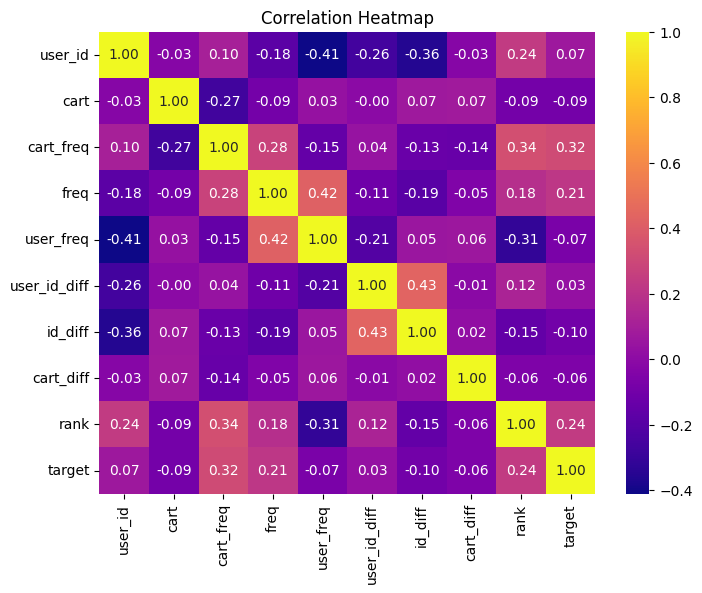

In [ ]:
corr = train_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='plasma', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Прямо скажем не фонтан, но давайте попробуем, в конце концов корреляция не особо показательна

# Построение модели

В качестве модели возьмем самый сильный бустинг - catboost,

In [ ]:
X, y = train_df.drop(['id', 'user_id', 'target'], axis =1 ), train_df['target']


И сразу попробуем сделать тривиальный отбор признаков, при помощи feature importance, для этого сгенерируем три столбца с рандомными признаками, если их важность окажется выше одной из наших фичей, то ее будет необходимо выкинуть

In [ ]:
X['useless1'] = np.random.choice(2, X.shape[0])
X['useless2'] = np.random.uniform(size =  X.shape[0])
X['useless13'] = np.random.randint(0, 10000, X.shape[0])


In [ ]:
model_cat = catboost.CatBoostClassifier(verbose=100)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)
model_cat.fit(X_train, y_train)

Learning rate set to 0.181244
0:	learn: 0.5865485	total: 277ms	remaining: 4m 36s
100:	learn: 0.4053538	total: 19.7s	remaining: 2m 55s
200:	learn: 0.4031281	total: 40.9s	remaining: 2m 42s
300:	learn: 0.4013957	total: 1m	remaining: 2m 20s
400:	learn: 0.3998148	total: 1m 21s	remaining: 2m 1s
500:	learn: 0.3983886	total: 1m 41s	remaining: 1m 41s
600:	learn: 0.3969851	total: 2m 1s	remaining: 1m 20s
700:	learn: 0.3956695	total: 2m 22s	remaining: 1m
800:	learn: 0.3944470	total: 2m 41s	remaining: 40.2s
900:	learn: 0.3932617	total: 3m 2s	remaining: 20.1s
999:	learn: 0.3921121	total: 3m 22s	remaining: 0us


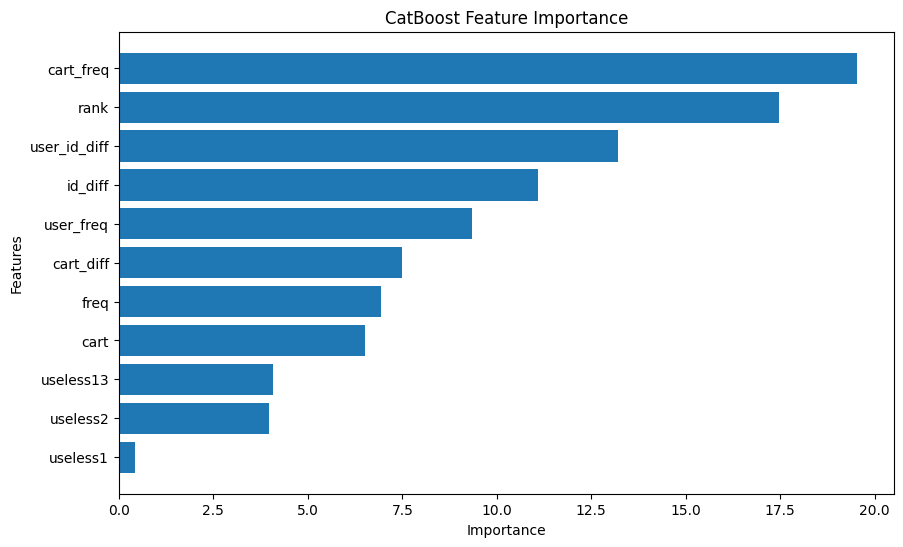

In [ ]:
importances = model_cat.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=X_train.columns).sort_values()
plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


Проверка на вшивость успешна пройдена, каждая из фичей оказалась минимально полезной

Теперь удалим бесполезные фичи

In [ ]:
X.drop(['useless1','useless2', 'useless13' ], axis =1 , inplace = True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)
model_cat.fit(X_train, y_train)

Learning rate set to 0.181244
0:	learn: 0.5876746	total: 328ms	remaining: 5m 27s
100:	learn: 0.4053606	total: 19.9s	remaining: 2m 57s
200:	learn: 0.4031921	total: 38.7s	remaining: 2m 33s
300:	learn: 0.4016167	total: 58.5s	remaining: 2m 15s
400:	learn: 0.4002175	total: 1m 17s	remaining: 1m 55s
500:	learn: 0.3989358	total: 1m 37s	remaining: 1m 36s
600:	learn: 0.3977498	total: 1m 55s	remaining: 1m 16s
700:	learn: 0.3966703	total: 2m 19s	remaining: 59.5s
800:	learn: 0.3956025	total: 2m 39s	remaining: 39.6s
900:	learn: 0.3945542	total: 2m 58s	remaining: 19.7s
999:	learn: 0.3935585	total: 3m 18s	remaining: 0us


In [ ]:
y_pred = model_cat.predict(X_test)
f1_score(y_pred, y_test)

0.32003050815139666

In [ ]:
y_test.sum()/X_test.shape[0], y_pred.sum()/X_test.shape[0] #на лицо сильный дисбаланас, будем менять тресхолд

(0.18811756378058123, 0.06615629272644409)

Попробуем подобрать порог по результату на тесте

In [ ]:
#тестовое множество и выбор порога
thresholds = np.arange(0.1, 0.4, 0.025)
y_pred_cat_proba = model_cat.predict_proba(X_test)[:,1]
best_f1_score = 0
best_threshold = None

for threshold in thresholds:
    y_pred_cat = np.where(y_pred_cat_proba < threshold, 0, 1)
    f1 = f1_score(y_test, y_pred_cat)
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold

print("Лучшее значение F1-меры:", best_f1_score)
print("Лучший порог:", round(best_threshold, 4))

Лучшее значение F1-меры: 0.4838224635721472
Лучший порог: 0.25


Сравним с результатами на обучающем множестве. Как мы можем видеть разница скоров минимальна, откуда следует, что сильного переобучения нет

In [ ]:
#обучающее множество
y_pred_cat_proba = model_cat.predict_proba(X_train)[:,1]
y_pred_cat = np.where(y_pred_cat_proba<0.25, 0, 1)
f1_score(y_train, y_pred_cat)

0.4978189793418267

# Отправка решения

In [ ]:
submission_df = train_generator_new(df)
submission_df = pd.merge(sample_submission[['id']], submission_df, on='id')
X_sub = submission_df[X.columns]

In [ ]:
model = catboost.CatBoostClassifier( verbose=False, random_seed= 777)
model.fit(X, y) #обучимся на всем множестве

In [ ]:
y_sub = model.predict_proba(X_sub)[:,1]
y_sub = np.where(y_sub<0.25, 0, 1)


In [ ]:
y_sub = model.predict_proba(X_sub)[:,1]
y_sub = np.where(y_sub<0.25, 0, 1)
result = submission_df[['id']]
result['target'] = y_sub
assert result.shape[0] == 790449, 'что-то пошло не так'
result.to_csv('finish.csv', index=False)
print('Смело отправляем')

Смело отправляем


На всякий случай сохраним итоговую модель

In [ ]:
file_name = 'catboost_model.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(model, file)

# Отчет о проделанной работе

**Результы**

На лидерборде на момент написания отчета у меня 37 место на лидерборде, с результатом 0.47623

Из явных преимуществ моего решения по сравнению с решениями выложенными в паблике - **крайне низкое переобучение**: на тесте на локальной машине скор был 0.483822, соответственно разница с лидербордом минимальная


# Неудачные эксперименты


**False golden feature**

В ходе экспериментов я добавлял в датасет время последней покупки, и локально она показала невероятно хороший результат - 0.78 на тестовом множестве, однако результат сабмита был удручающим - всего 0.418. Из этого был сделан вывод, что фича является бесполезной, так как она содержит информацию, которая в реальности неизвестна.

**Тюнинг**

Была попытка воспользоваться **optuna** для улучшения результата. Однако так как датасет немаленький (согласно эмпирическому правилу тюниг для больших дататсетов бесполезен) улучшение скора не произошло.

**Ансамбль**

Пытался ансамблировать catboost c другими бустингами, повысить скор не удалось.

Также пытался ансамблить catboost с наивным баесом, однако желаемого результа это также не принесло, несмотря на то что, сам по себе наивный баес на логарифмированных фичах давал скор 0.43 на тестовом множестве и 0.40 на лидерборде


**Использование auto-ml**

Считается гораздо быстрее чем catboost, однако результат на лидерборде оказался хуже - всего 0.470